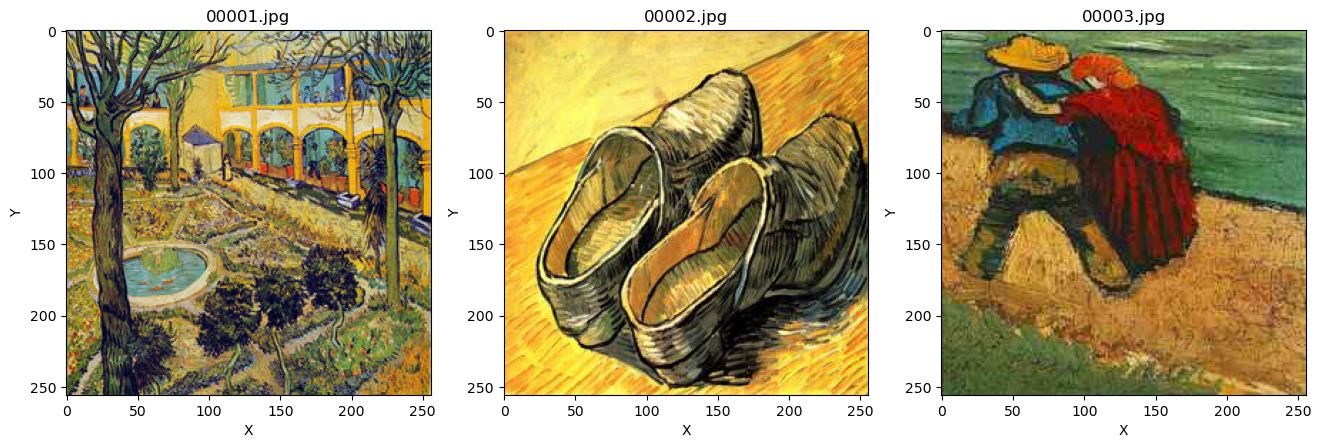

In [3]:
# shifting / mapping color from portrait to image
import os
import numpy as np
from skimage import io                             # io for image
from skimage.color import rgb2lab, lab2rgb         # color channal transformation
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt

# visualize some of the image
image_dir = 'datasets/style_transfer'
data_dir = os.path.join(image_dir, 'vangogh')
data_names = os.listdir(data_dir)
# print(data_names)

fig = plt.figure(figsize=(16, 5))
for i, image_name in enumerate(np.asarray(data_names)[:3]):
    img = io.imread(os.path.join(data_dir, image_name))
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(img)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(image_name)
plt.show()

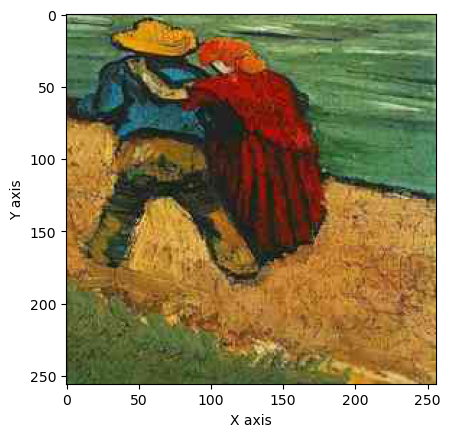

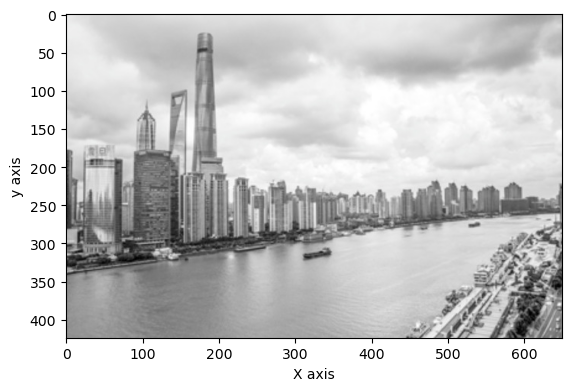

Constructing window...
Predicting...


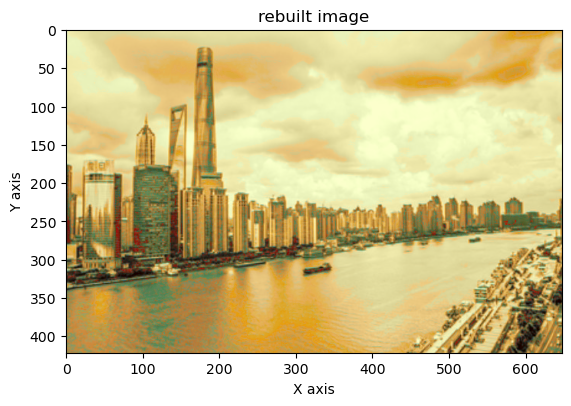

In [9]:
# Questions/Problems: How to mapping artistical style onto real photo ?
# Solution: KNN transference - gray value as features, color as labels
# In detail:
# 1. Read:             stylish image 
#    Transfer:         into LAB mode, 
#    Construct data:   'window' size on the image with only L channel(shape[0]),
#                      L channel(black and white) for features, AB(color) channel for labels
# 2. Fit model
#
# 3. Read:             photos, transfer as well, 
#    Construct data:   'window' size of data on the image with only L channel(shape[0]),
#    Predict:          the possible color regarding the L channel data of photo

border_size = 1  # represent the enlarged part of 3x3 window

def read_style_image(image_name, size=border_size):
    # show read image
    img = io.imread(image_name)
    fig = plt.figure()
    plt.imshow(img)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()

    # channel transformation: RGB to LAB
    img = rgb2lab(img)
    w, h = img.shape[:2]                                       # shape: W x H x Channel(3, LAB)
    X = []
    Y = []

    for x in range(size, w - size):                            # width border
        for y in range(size, h - size):                        # height border
            X.append(img[x - size : x + size + 1, 
                         y - size : y + size + 1, 
                         0].flatten())                         # flatten it for algorithm
            Y.append(img[x, y, 1:])                            # store AB of color channel
    return X, Y

# read stylish image data
X, y = read_style_image(os.path.join(data_dir, np.array(data_names)[2]))

# KNN model
knn = KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X, y)

# predict real photo
def rebuild(file_name, size=border_size):
    # show read image
    img = io.imread(file_name)
    fig = plt.figure()
    plt.imshow(img)
    plt.xlabel('X axis')
    plt.ylabel('y axis')
    plt.show()

    # channel transformation: RGB to LAB
    img = rgb2lab(img)
    w, h = img.shape[:2]

    # construct and store photo's window data
    photo = np.zeros(shape=(w, h, 3))
    print('Constructing window...')
    X = []                                                         # we only need to store windows, y is waited for prediction
    for x in range(size, w - size):
        for y in range(size, h - size):
            X.append(img[x - size : x + size + 1, 
                         y - size : y + size + 1, 
                         0].flatten())
    X = np.array(X)

    # prediction
    print('Predicting...')
    pred = knn.predict(X).reshape(w - 2 * size, h - 2 * size, -1)  # the result pixels should be shifted back to original size
    photo[:, :, 0] = img[:, :, 0]                                  # 1. assign the third channel of color channel - light
    photo[size : w - size, size : h - size, 1:] = pred             # 2. assign ab prediction result for actual color
    photo = photo[size : w - size, size : h - size, :]             # 3. discard part of photo that can not be constructed as a window
    return photo

rebuilt_img = rebuild(os.path.join(image_dir, 'input.jpg'))
rgb_result = lab2rgb(rebuilt_img)

fig = plt.figure()
plt.imshow(rgb_result)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('rebuilt image')
plt.show()